# Explorative data analysis of real world data on multiple sclerosis

This script will perform the data import, cleaning and further processing as well as data exploration to tackle the following research questions:

- Which of the collected metrics show differences between people with multiple sclerosis and controls?
- Does the mood (or self-reported well-being) correlate with some of the gathered metrics?
- Can we use the dataset to monitor and track symptomatic progresses?
---

# 1) Import the data

We start our analysis by importing required libraries:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats
import pandas as pd
import seaborn as sns
import datetime
from datetime import date
import holidays
from scipy import stats
from collections import Counter
sns.set_palette("RdBu_r", 7) # this sets the color palette
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', None) # display all columns

Loading the data and deleting useless columns:

In [69]:
df = pd.read_csv('complete_dataset.csv')#, nrows=50000) # 'nrows=50000' for reduced data import
df = df.drop(['testResultMetricTimestamp1','testResultMetricTimestamp2','Unnamed: 19'], axis=1)

Check if we have missing (nan) values:

In [3]:
missing_values = df.isnull().sum()
print(missing_values)

floodlightOpenId                 0
participantCreatedOn             0
participantIsControl             0
participantCountryOfResidence    0
participantSex                   0
participantBirthYear             0
participantWeightLbs             0
participantHeightCms             0
testName                         0
testCode                         0
testMetricName                   0
testMetricCode                   0
testStartedAt                    0
testEndedAt                      0
testResultMetricId               0
testResultMetricCreatedOn        0
testResultMetricValue            0
dtype: int64


In [4]:
shape1 = df.shape
df = df.dropna()
shape2 = df.shape
if shape1 == shape2:
    print('Data contains no nan values.')
else:
    print('Data contains nan values.')

Data contains no nan values.


Good. Let's look at the first couple of rows in our dataframe:

In [70]:
df.head()

,floodlightOpenId,participantCreatedOn,participantIsControl,participantCountryOfResidence,participantSex,participantBirthYear,participantWeightLbs,participantHeightCms,testName,testCode,testMetricName,testMetricCode,testStartedAt,testEndedAt,testResultMetricId,testResultMetricCreatedOn,testResultMetricValue
0,FL10038084,4/23/2018 12:12:03 AM +00:00,True,US,male,1966,159.0,178.0,Daily Questions,daily_questions,Mood Response,mood_response,4/23/2018 12:22:55 AM +00:00,4/23/2018 12:22:55 AM +00:00,115524,4/23/2018 12:22:57 AM +00:00,4.00
1,FL10038084,4/23/2018 12:12:03 AM +00:00,True,US,male,1966,159.0,178.0,Daily Questions,daily_questions,Mood Response,mood_response,4/25/2018 4:04:31 AM +00:00,4/25/2018 4:04:31 AM +00:00,116040,4/25/2018 4:04:32 AM +00:00,5.00
2,FL10038084,4/23/2018 12:12:03 AM +00:00,True,US,male,1966,159.0,178.0,Information Processing Speed Baseline Test,ips_baseline,Correct Responses,correct_responses,4/25/2018 4:06:35 AM +00:00,4/25/2018 4:06:51 AM +00:00,116041,4/25/2018 4:06:51 AM +00:00,16.00
3,FL10038084,4/23/2018 12:12:03 AM +00:00,True,US,male,1966,159.0,178.0,Information Processing Speed Baseline Test,ips_baseline,Response Time Average,response_time_avg,4/25/2018 4:06:35 AM +00:00,4/25/2018 4:06:51 AM +00:00,116042,4/25/2018 4:06:51 AM +00:00,0.94
4,FL10038084,4/23/2018 12:12:03 AM +00:00,True,US,male,1966,159.0,178.0,IPS,ips,Correct Responses,correct_responses,4/25/2018 4:06:35 AM +00:00,4/25/2018 4:06:51 AM +00:00,116043,4/25/2018 4:06:51 AM +00:00,39.00


Converting the date string format to datetime:

In [71]:
df['participantCreatedOn'] = [datetime.datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p %z') for x in df['participantCreatedOn']]
df['testStartedAt'] = [datetime.datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p %z') for x in df['testStartedAt']]
df['testEndedAt'] = [datetime.datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p %z') for x in df['testEndedAt']]
df['testResultMetricCreatedOn'] = [datetime.datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p %z') for x in df['testResultMetricCreatedOn']]

The dataframe contains data about:
- anthropomorphic data (age, sex, height and weight) of the participants
- identifier of the participant (Id)
- identifier of MS diagnosis ('participantIsControl')
- identifier of the reported test metric
- value and time of result logging

Ok, lets have a look at the descriptive statistics to check if the entries are reasonable:

In [7]:
df.describe()

,participantBirthYear,participantWeightLbs,participantHeightCms,testResultMetricId,testResultMetricValue
count,215759.000000,215759.000000,215759.000000,215759.000000,215759.000000
mean,1971.662610,172.335119,167.532381,142008.888895,28.120221
std,12.602808,55.011890,23.823953,79700.368559,241.647506
min,1900.000000,3.000000,1.000000,66.000000,0.000000
25%,1963.000000,136.000000,163.000000,53735.500000,0.130000
50%,1971.000000,162.000000,170.000000,159816.000000,1.000000
75%,1980.000000,190.000000,178.000000,215022.500000,6.000000
max,2019.000000,552.000000,250.000000,245354.000000,30316.670000


We can see that some of the entries are not reasonable (e.g. weight = 3 Lbs). In order to clean unreasonable samples, and to restrict our analysis to more confined ranges we delete samples that do not meet the following criteria:
- age between 18 and 100
- weight above 100 Lbs
- height above 150 Cms

In [72]:
df = df.drop(df[(df['participantBirthYear'] < 1920) | (df['participantBirthYear'] > 2002) | (df['participantWeightLbs'] < 100) | (df['participantHeightCms'] < 150)].index)

In [9]:
df.describe()

,participantBirthYear,participantWeightLbs,participantHeightCms,testResultMetricId,testResultMetricValue
count,207958.000000,207958.000000,207958.000000,207958.000000,207958.000000
mean,1971.476606,173.115696,170.629449,142562.489969,28.344196
std,11.098155,54.555133,10.109646,80082.167168,241.416512
min,1921.000000,100.000000,150.000000,66.000000,0.000000
25%,1964.000000,137.000000,163.000000,53674.250000,0.130000
50%,1971.000000,162.000000,170.000000,161253.500000,1.000000
75%,1979.000000,190.000000,178.000000,216229.750000,6.300000
max,2002.000000,552.000000,226.000000,245354.000000,30316.670000


---
# 2) Explorative data analysis

To better understand the data, we will look at the proportion of gender, as well as positive and negative diagnosis:

In [10]:
df.groupby(['participantSex'])['participantIsControl'].value_counts()

participantSex  participantIsControl
female          False                   124077
                True                     19410
male            False                    37798
                True                     26673
Name: participantIsControl, dtype: int64

Text(0.5, 1.0, 'participants per gender and control')

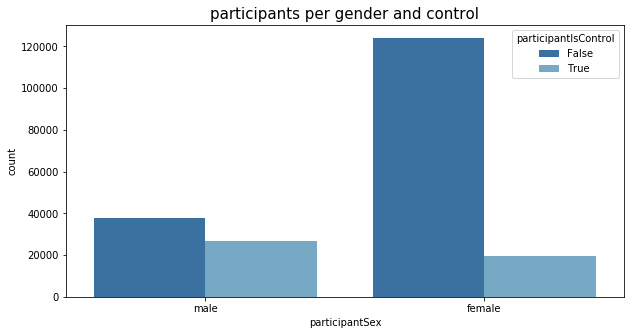

In [11]:
fig = plt.figure(figsize=(10,5))
sns.countplot(x = df['participantSex'], hue = df['participantIsControl'])
plt.title("participants per gender and control", fontsize = 15)

Now, lets have a look where the participants come from:

In [12]:
countries = df['participantCountryOfResidence'].value_counts()
df.groupby(['participantSex'])['participantCountryOfResidence'].value_counts()

participantSex  participantCountryOfResidence
female          US                               75934
                CA                               28719
                DK                               25688
                IT                                7714
                CH                                2445
                ES                                2299
                AU                                 282
                BE                                 254
                FI                                  62
                BR                                  38
                CZ                                  35
                PL                                  17
male            US                               25598
                CA                               14281
                DK                               10965
                IT                                6327
                CH                                5831
                ES 

<function matplotlib.pyplot.show(*args, **kw)>

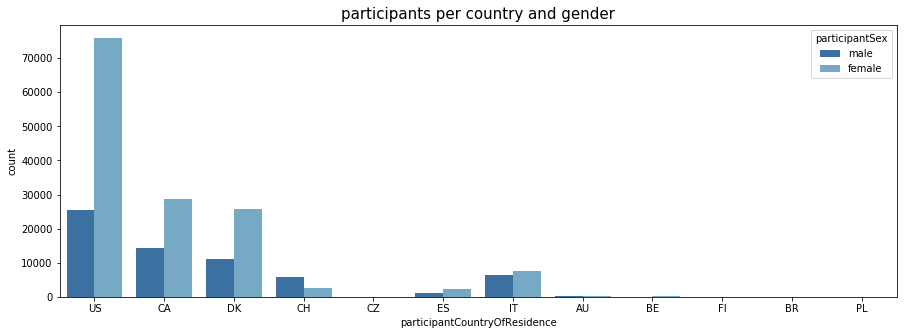

In [13]:
fig = plt.figure(figsize=(15,5))
sns.countplot(x = df['participantCountryOfResidence'], hue = df['participantSex'])
plt.title("participants per country and gender", fontsize = 15)
plt.show
#my_circle=plt.Circle( (0,0), 0.7, color='white')
#fig = plt.figure(figsize=(15,5))
#plt.pie(countries.values, labels=countries.index,wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })
#fig.gca().add_artist(my_circle)
#plt.title("participants per country", fontsize = 15)
#plt.show()

How are anthropomorphic data distributed among all participants?

<function matplotlib.pyplot.show(*args, **kw)>

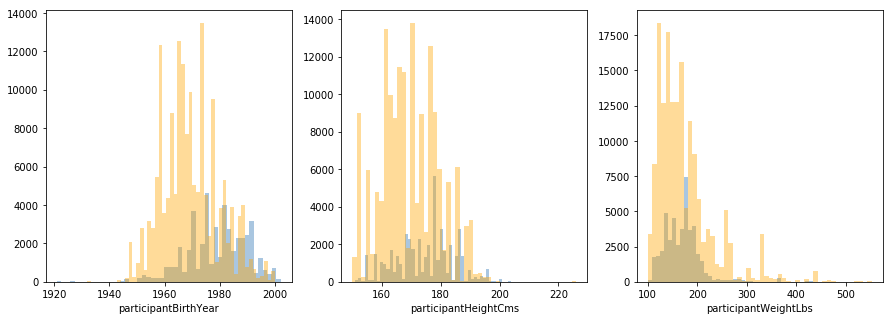

In [14]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
sns.distplot(df['participantBirthYear'][(df['participantIsControl']==True)], kde=False, ax=ax1)
sns.distplot(df['participantBirthYear'][(df['participantIsControl']==False)], color='orange', kde=False, ax=ax1)
sns.distplot(df['participantHeightCms'][(df['participantIsControl']==True)], kde=False, ax=ax2)
sns.distplot(df['participantHeightCms'][(df['participantIsControl']==False)], color='orange', kde=False, ax=ax2)
sns.distplot(df['participantWeightLbs'][(df['participantIsControl']==True)], kde=False, ax=ax3)
sns.distplot(df['participantWeightLbs'][(df['participantIsControl']==False)], color='orange', kde=False, ax=ax3)
plt.show

In these plots, the year of birth, the height and the weight are shown for diagnosed (orange) and control (blue) participants. We can see that people with a MS diagnosis are generelly older, smaller and with similar weight.

But before we move on, lets first do a little _feature engineering_ to derive more features from the existing data. One thing to add is the day of the week that is derived from the date of the test and if that day was a holiday in the particular country. I will also calculate the time that is gone since the participant registered.

In [73]:
df['Delta_test_register'] = df['testResultMetricCreatedOn'] - df['participantCreatedOn']
df['Weekday_testResultCreatedOn'] = [x.isoweekday() for x in df['testResultMetricCreatedOn']]

In [74]:
def HolidayCountry(country_in, date_in):
    holidays_country = holidays.CountryHoliday(country_in)
    is_holiday = date_in.date() in holidays_country
    return is_holiday

In [75]:
is_holi = []
m = 0
for x in df['testResultMetricCreatedOn']:
    is_holi.append(HolidayCountry(df['participantCountryOfResidence'].iloc[m],x))
df['Holiday_testResultCreatedOn'] = is_holi

Now, lets have a look at the created test observations over the time of the dataset.

In [85]:
# create the number of observations per week for each subject
num_subjects = len(df['floodlightOpenId'].unique())
Delta_days = []
Delta_weeks = []
for x in df['Delta_test_register']:
    days_ceil = x.ceil('D').days
    Delta_days.append(days_ceil)
    Delta_weeks.append(days_ceil//7)
df['Delta_Dayss_test_register'] = Delta_days
df['Delta_Weeks_test_register'] = Delta_weeks
num_weeks = df['Delta_Weeks_test_register'].max()
count_weeks = np.zeros((num_weeks,num_subjects)) # pre-define matrix
j = 0
weeks_subject = []
week_counts = []
for num, name in enumerate(df['floodlightOpenId'].unique()): # loop over all subjects
    weeks_subject = df['Delta_Weeks_test_register'][(df['floodlightOpenId'] == name)]
    week_counts = Counter(weeks_subject)
    for i in week_counts: # loop over all entries
        count_weeks[i-1,j] = week_counts[i]
    j = j+1    

To get an overview of observations per subject, we visualize the number of test performed per week.

Text(0.5, 1.0, 'Number of weekly test results of all participants')

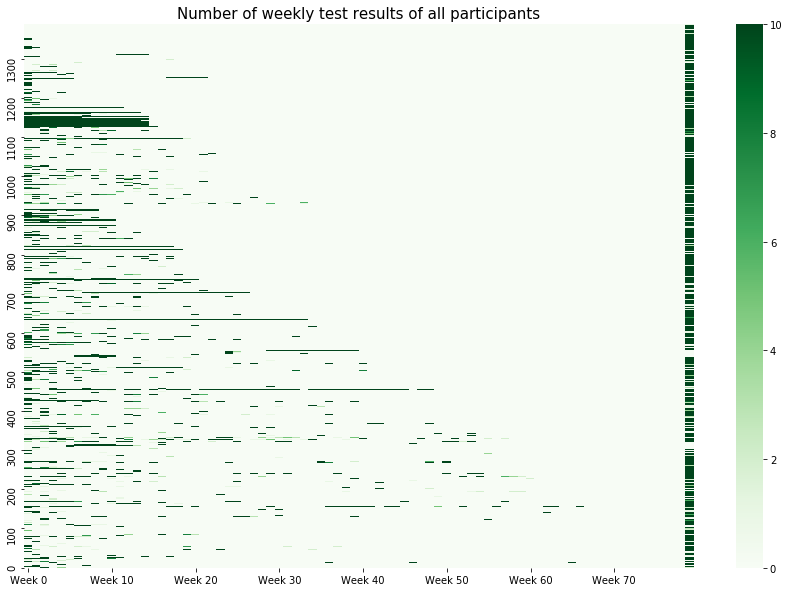

In [77]:
fig = plt.figure(figsize=(15,10))
df_count_weeks = pd.DataFrame(data=count_weeks.transpose())
df_count_weeks = df_count_weeks.add_prefix('Week ')
ax = sns.heatmap(df_count_weeks,cmap = "Greens", vmax = 10, xticklabels=10, yticklabels=100)
ax.invert_yaxis()
plt.title('Number of weekly test results of all participants', fontsize = 15)

This plot shows the activity of the particpants to perform test since they registered. Ideally, this plot would be roughly like a triangle, meaning that all participants logged multiple tests per week (without empty spaces). Instead, most participants performed the test in the first weeks. Howerver, some participants kept on performing the tests regularly, as seen by horizontal lines.

Moving on with the test names:

In [ ]:
metric_Names = df['testName'].unique().astype(str)
print(metric_Names)

The Baseline Test will for now be excluded from the data set. However, to not lose the data, we create a new dataframe:

In [78]:
df_baseline = df[(df['testName'] == 'Information Processing Speed Baseline Test')]
df = df.drop(df[(df['testName'] == 'Information Processing Speed Baseline Test')].index)
df.reset_index(drop=True);

In [ ]:
metric_Names = df['testName'].unique().astype(str)
print(metric_Names)

Now, I start plotting the individual metrics to check if diagnosed and control participants differ. The test metrics are:

In [ ]:
metric_labels = df['testMetricName'].unique().astype(str)
print(metric_labels)

Notice that the number of observations for each metric differs:

In [ ]:
fig = plt.figure(figsize=(15,5))
sns.countplot(x = df['testMetricName'], hue = df['participantIsControl'])
plt.title("number of test results per metric", fontsize = 15)
plt.xticks(rotation=90)
plt.show

Since the test result data is widely spread, we first exclude the outliers in order to get a better picture about both groups. Here, I argue that the test results are affected by measurement error; since the data was collected by a smartphone and in uncontrolled scenarios. However, if you want to visualze the whole dataset, set the 'hide_out' parameter to 0.

In [79]:
hide_out = 1 # 0: include, 1: exclude
def exclude_outliers(data_in): # uses the common 1.5*IQR criterion to exclude outliers
    Q1 =  data_in['testResultMetricValue'].quantile(0.25)
    Q3 =  data_in['testResultMetricValue'].quantile(0.75)
    IQR = Q3 - Q1
    data_out = data_in.drop(data_in[(data_in['testResultMetricValue'] < Q1-1.5*IQR ) | (data_in['testResultMetricValue'] > Q3+1.5*IQR)]['testResultMetricValue'].index)   
    return data_out

In [80]:
m = 0
data_metrics = np.empty((len(df),len(metric_labels))) # pre-define matrix
data_metrics[:] = np.nan
for i in metric_labels: # loop through all metrics
    data_plot = df[(df['testMetricName'] == i)]
    samples = data_plot.shape
    if hide_out == 1: # check if data should be excluded
        data_plot = exclude_outliers(data_plot)
    num_plot = len(data_plot[data_plot['participantIsControl'] == False])    
    data_metrics[:num_plot,m] = data_plot['testResultMetricValue'][(data_plot['participantIsControl'] == False)] # for corrlations
    # plot metrics
    m = m+1
    fig = plt.figure(m)
    ax = sns.boxplot(x="participantIsControl", y="testResultMetricValue", data=data_plot, fliersize = False)
    
    # Calculate number of obs per group & median to position labels
    medians = data_plot.groupby(['participantIsControl'])['testResultMetricValue'].median().values
    means = data_plot.groupby(['participantIsControl'])['testResultMetricValue'].mean().values
    nobs = data_plot['participantIsControl'].value_counts().values
    nobs = [x for x in nobs.tolist()]
    nobs = [i for i in nobs]
    print("samples MS: %d, samples Controls: %d" % (nobs[0],nobs[1]))
    print("Mean MS: %2.2f, Mean Controls: %2.2f" % (means[0],means[1]))
    plt.title(i, fontsize = 15)
    plt.show()

NameError: name 'metric_labels' is not defined

With these plots, we can answer the first research question:  
**_'Which of the collected metrics show differences between people with multiple sclerosis and controls?'_**

- participants with MS responded with lower mood than controls
- appart from that no clear difference can be found
---

Now lets calculate the pearson correlations between the different metrics. For this, we use the dataset with excluded outliers because outliers can distord these calculations. Further, we need also drop the categorial feature 'Hand Used' since this is not really helpful for this analysis.

In [ ]:
df_metrics = pd.DataFrame(data=data_metrics,columns=metric_labels)
df_metrics.drop(columns=['Hand Used'],inplace = True)

In [ ]:
plt.figure(figsize=(30, 25))
p = sns.heatmap(df_metrics.corr(), annot=True)

To answer the second research question:  
**_'Does the mood (or self-reported well-being) correlate with some of the gathered metrics?'_**

- No, only very poor correlations are found
- Also, no other correlations between metrics can be found. The only exception is the perfect correlation of 'Mean Hausdorf Distance Best' and the 'Top to Bottom Hausdorf Distance Best'. This, however, is due to the fact that for both metrics contain almost no variance. One should check how these values are calculated in the raw dataset because this result suggests that both metrics are inherently correlated, e.g. in the way they are calculated. 

---

In [86]:
%store df

Stored 'df' (DataFrame)
